In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import interp1d
from scipy.integrate import quad, solve_ivp
import astropy.units as u
import astropy.constants as const
import os
from numba import jit
from pdr_functions import *

lines_folder = "solve_rte/"

In [2]:
qtydict = {
    "AV": 0,
    "Distance": 1,
    "nH": 2,
    "Temperature": 3,
    "n(H)": 4,
    "n(H2)": 5,
    "n(C+)": 6,
    "n(C)": 7,
    "n(CO)": 8,
    "n(13CO)": 9,
    "n(C_18O)": 10,
    "n(O)": 11,
    "n(H2O)": 12,
    "n(H2O J=1,ka=1,kc=0)": 13,
    "n(C+ El=2P,J=3/2)": 14,
    "n(C El=3P,J=1)": 15,
    "n(CO v=0,J=2)": 16,
    "n(CO v=0,J=4)": 17,
    "n(13CO J=2)": 18,
    "n(C_18O J=2)": 19
}

linedict = {
    "n(C+ El=2P,J=3/2)" : 0,
    "n(C+ El=2P,J=1/2)" : 1,
    "n(C El=3P,J=0)" : 2,
    "n(C El=3P,J=1)" : 3,
    "n(CO v=0,J=1)" : 4,
    "n(CO v=0,J=2)" : 5,
    "n(CO v=0,J=3)" : 6,
    "n(CO v=0,J=4)" : 7,
    "n(H2O J=1,ka=0,kc=1)" : 8,
    "n(H2O J=1,ka=1,kc=0)" : 9
}

def dist_2_arcsec(dists, dist2obj=400*u.pc):
    """convert given distance array to arcsec

    Args:
        dists (float ndarray with unit): distance array to be converted
        dist2obj (float with unit, optional): distance to the object. Defaults to 400*u.pc (the distance to the horsehead nebula).

    Returns:
        _type_: distance array as in arcsec
    """
    return (dists.to(u.pc)/dist2obj*u.rad).to(u.arcsec)

def arcsec_2_dist(arcsecs, distunit="cm", dist2obj=400*u.pc):
    """convert given distance array in arcsec to physical distance

    Args:
        arcsecs (float ndarray): distance array in arcsec to be converted
        distunit (str, optional): physical distance unit to be converted into. Defaults to "cm".
        dist2obj (float with unit, optional): distance to the object. Defaults to 400*u.pc (the distance to the horsehead nebula).

    Returns:
        _type_: _description_
    """
    if distunit == "cm":
        return (arcsecs.to(u.rad)).value*dist2obj.to(u.cm)
    elif distunit == "pc":
        return (arcsecs.to(u.rad)).value*dist2obj.to(u.pc)

In [3]:
##### load data #####
# models (number density, temperature, etc.)
params = ["thick_p5e6_h2_surfb"]
models = {}
for param in params:
    models[param] = np.genfromtxt(f"horsehead_{param}", skip_header=6, unpack=True)

# level densities
model_lines = np.genfromtxt("horsehead_thick_p5e6_h2_surfb_lines", skip_header=6, unpack=True)

# background intensity
bkg_intensity = np.genfromtxt("horsehead_thick_p5e6_h2_surfb_IncRadField.dat", skip_header=10, unpack=True)

### PDR structure

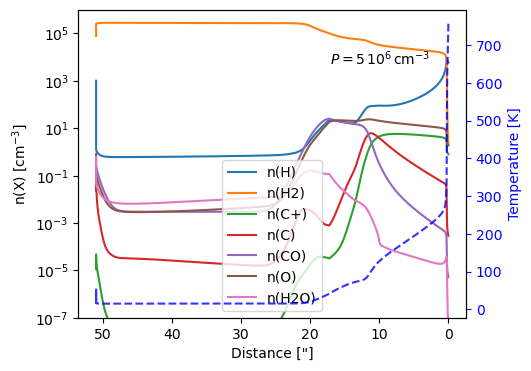

In [4]:
fig_struct, ax_struct = plot_structure(models[params[0]], qtydict, densities = ["n(H)", "n(H2)", "n(C+)", "n(C)", "n(CO)", "n(O)", "n(H2O)"], xvar="arcsec",  ylim=[1e-7, 1e6], legendloc="lower center", title=r"$P = 5\,10^6\,\mathrm{cm}^{-3}$", titleloc=(0.65, 0.82), save=False)

ax_temp = ax_struct.twinx()
ltemp, = ax_temp.plot(dist_2_arcsec(models[params[0]][qtydict["Distance"]]*u.cm), models[params[0]][qtydict["Temperature"]], c="b", ls="--", label="T", alpha=0.8)
ax_temp.set_ylabel("Temperature [K]")
ax_temp.yaxis.label.set_color(ltemp.get_color())
ax_temp.tick_params(axis='y', colors=ltemp.get_color())

### Column Densities

In [5]:
### compare slab and spherical geometry, normalized ###

plot_model_surfb = models["thick_p5e6_h2_surfb"]

plot_model_surfb_x_cm = plot_model_surfb[qtydict["Distance"]]*u.cm
plot_model_surfb_x_pc = plot_model_surfb[qtydict["Distance"]]*u.cm.to(u.pc)
b_crital = plot_model_surfb_x_pc[-1]
line_labels = ["N(C+ El=2P,J=3/2)", "N(C El=3P,J=1)", "N(CO v=0,J=2)", "N(CO v=0,J=4)", "N(H2O J=1,ka=1,kc=0)"]
line_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
lines = ["n(C+ El=2P,J=3/2)", "n(C El=3P,J=1)", "n(CO v=0,J=2)", "n(CO v=0,J=4)", "n(H2O J=1,ka=1,kc=0)"]

Rcloud_pc = 5*u.pc
barr_pc = np.linspace(4.85, 5, 200)*u.pc

Rcloud_cm = Rcloud_pc.to(u.cm).value
barr_cm = barr_pc.to(u.cm).value

xarr_uniq, xarr_uniqindices = np.unique(plot_model_surfb_x_cm, return_index=True)

column_densities = []
for line in lines:
    yval = plot_model_surfb[qtydict[line]]
    column_density_y = np.zeros_like(barr_cm, dtype=float)
    column_density_slab_y = np.zeros_like(barr_cm, dtype=float)

    func_loc_density = interp1d(xarr_uniq, yval[xarr_uniqindices])
    densities_slab_surfb = np.interp(Rcloud_cm - barr_cm, plot_model_surfb_x_cm.value, plot_model_surfb[qtydict[line]])
    
    for i, b in enumerate(barr_cm):
        column_density_y[i], smin, smax = column_density(Rcloud_cm, b, plot_model_surfb_x_cm, yval, func_loc_density)
        # column_density_y[i], smin, smax = column_density(Rcloud_cm, b, plot_model_surfb_x_cm, yval)
        column_density_slab_y[i] = 2*densities_slab_surfb[i]*(smax - smin)
        
    column_densities.append(column_density_y)

/Users/luducheng/Research/ISM/PDR_data_analysis/liu_report/solve_rte/pdr_functions.py:647: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  col_density, _ = quad(func_los_loc_density, smin, smax, limit=500)


/var/folders/8_/fcjn7dkn3nx5lzmncyf9q_nr0000gn/T/ipykernel_85918/2914448219.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_colden.tight_layout(w_pad=0, h_pad=0)


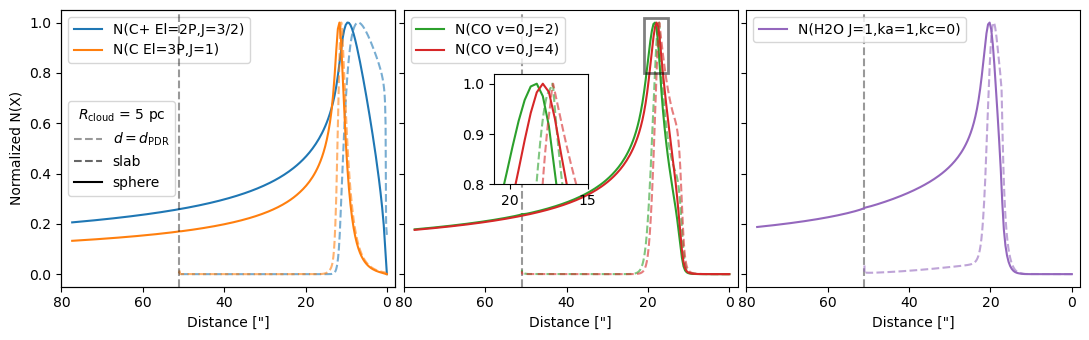

In [6]:
fig_colden, axs_colden = plt.subplots(1, 3, figsize=(11, 3.5), sharey=True)
ax1_twin = axs_colden[0].twinx()
ax1_twin.set_yticks([])

b_crital_arcsec = dist_2_arcsec(b_crital*u.pc).value

ax1_twin.axvline(b_crital_arcsec, 0, 1, linestyle="--", c="k", alpha=0.4, label=r"$d = d_\mathrm{PDR}$")
ax1_twin.plot(np.nan, np.nan, "k--", alpha=0.6, label="slab")
ax1_twin.plot(np.nan, np.nan, "k-", label="sphere")
axs_colden[1].axvline(b_crital_arcsec, 0, 1, linestyle="--", c="k", alpha=0.4)
axs_colden[2].axvline(b_crital_arcsec, 0, 1, linestyle="--", c="k", alpha=0.4)

ax2_axin = inset_axes(axs_colden[1], width="40%", height="40%", loc="center left", bbox_to_anchor=(0.25, 0.07, 0.7, 1), bbox_transform=axs_colden[1].transAxes)

xarr_arcsec = dist_2_arcsec(plot_model_surfb_x_cm).value
colden_xarr_arcsec = dist_2_arcsec(Rcloud_pc - barr_pc).value

for iline, line in enumerate(lines):
    max_column_density_surfb = column_densities[iline].max()
    if iline < 2:
        axs_colden[0].plot(xarr_arcsec, plot_model_surfb[qtydict[line]]/plot_model_surfb[qtydict[line]].max(), "--", c=line_colors[iline], alpha=0.6)
        axs_colden[0].plot(colden_xarr_arcsec, column_densities[iline]/max_column_density_surfb, "-", c=line_colors[iline], label=line_labels[iline], markevery=0.1)
    elif iline < 4:
        axs_colden[1].plot(xarr_arcsec, plot_model_surfb[qtydict[line]]/plot_model_surfb[qtydict[line]].max(), "--", c=line_colors[iline], alpha=0.6)
        axs_colden[1].plot(colden_xarr_arcsec, column_densities[iline]/max_column_density_surfb, "-", c=line_colors[iline], label=line_labels[iline])
        ax2_axin.plot(xarr_arcsec, plot_model_surfb[qtydict[line]]/plot_model_surfb[qtydict[line]].max(), "--", c=line_colors[iline], alpha=0.6)
        ax2_axin.plot(colden_xarr_arcsec, column_densities[iline]/max_column_density_surfb, "-", c=line_colors[iline], label=line_labels[iline], markevery=0.1)
    else:
        axs_colden[2].plot(xarr_arcsec, plot_model_surfb[qtydict[line]]/plot_model_surfb[qtydict[line]].max(), "--", c=line_colors[iline], alpha=0.6)
        axs_colden[2].plot(colden_xarr_arcsec, column_densities[iline]/max_column_density_surfb, "-", c=line_colors[iline], label=line_labels[iline], markevery=0.1)

for ax in axs_colden:
    ax.legend(loc="upper left")
    # ax.set_xlabel(f"Distance [{u.pc}]")
    ax.set_xlabel(f'Distance ["]')
    ax.set_xlim([-2, 80])
    ax.invert_xaxis()

ax2_axin.set(xlim=(15, 21), ylim=(0.8, 1.02))
ax2_axin.invert_xaxis()
axs_colden[1].indicate_inset_zoom(inset_ax=ax2_axin, edgecolor="k", lw=2)
ax1_twin.legend(loc="center left", title=r"$R_\mathrm{cloud}$ = 5 pc")

axs_colden[0].set_ylabel("Normalized N(X)")

fig_colden.tight_layout(w_pad=0, h_pad=0)
# fig_colden.savefig(figure_path+"column_densities.pdf", bbox_inches="tight", pad_inches=0)

### Convolution

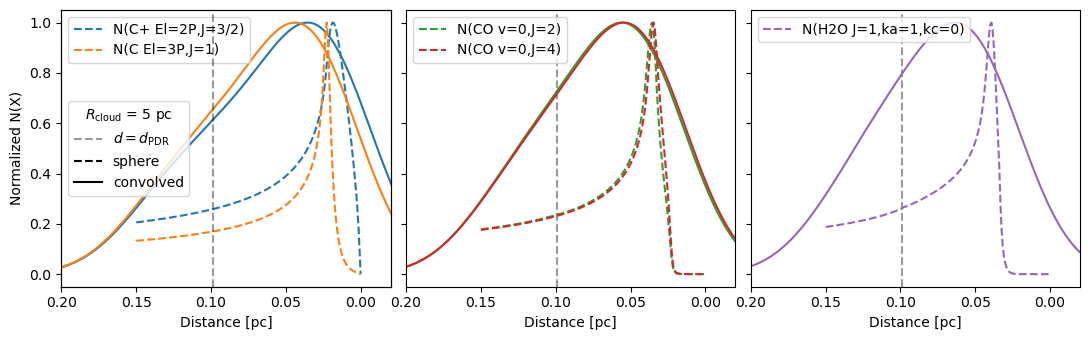

In [7]:
convv_data_38p1, convv_x_38p1 = convolve_uniform(Rcloud_cm - barr_cm, column_densities, arcsec_2_dist(38.1*u.arcsec).value, expandx=True)
convv_x_38p1_pc = convv_x_38p1*u.cm.to(u.pc)

fig_convvcolden, axs_convvcolden = plt.subplots(1, 3, figsize=(11, 3.5), sharey=True)
ax1_twin = axs_convvcolden[0].twinx()
ax1_twin.set_yticks([])

ax1_twin.axvline(b_crital, 0, 1, linestyle="--", c="k", alpha=0.4, label=r"$d = d_\mathrm{PDR}$")
# ax1_twin.plot(np.nan, np.nan, "k-", alpha=0.6, label="slab")
ax1_twin.plot(np.nan, np.nan, "k--", label="sphere")
ax1_twin.plot(np.nan, np.nan, "k-", label="convolved")
axs_convvcolden[1].axvline(b_crital, 0, 1, linestyle="--", c="k", alpha=0.4)
axs_convvcolden[2].axvline(b_crital, 0, 1, linestyle="--", c="k", alpha=0.4)

for iline, line in enumerate(lines):
    max_column_density_surfb = column_densities[iline].max()
    if iline < 2:
        axs_convvcolden[0].plot(Rcloud_pc - barr_pc, column_densities[iline]/max_column_density_surfb, "--", c=line_colors[iline], label=line_labels[iline])
        # axs_convvcolden[0].plot(plot_model_surfb_x_pc, plot_model_surfb[quantities[line]]/plot_model_surfb[quantities[line]].max(), "-", c=line_colors[iline], alpha=0.6)
        axs_convvcolden[0].plot(convv_x_38p1_pc, convv_data_38p1[iline]/convv_data_38p1[iline].max(), "-", c=line_colors[iline])
    elif iline < 4:
        axs_convvcolden[1].plot(Rcloud_pc - barr_pc, column_densities[iline]/max_column_density_surfb, "--", c=line_colors[iline], label=line_labels[iline])
        # axs_convvcolden[1].plot(plot_model_surfb_x_pc, plot_model_surfb[quantities[line]]/plot_model_surfb[quantities[line]].max(), "-", c=line_colors[iline], alpha=0.6)
        axs_convvcolden[1].plot(convv_x_38p1_pc, convv_data_38p1[iline]/convv_data_38p1[iline].max(), "-", c=line_colors[iline])
    else:
        axs_convvcolden[2].plot(Rcloud_pc - barr_pc, column_densities[iline]/max_column_density_surfb, "--", c=line_colors[iline], label=line_labels[iline])
        # axs_convvcolden[2].plot(plot_model_surfb_x_pc, plot_model_surfb[quantities[line]]/plot_model_surfb[quantities[line]].max(), "-", c=line_colors[iline], alpha=0.6)
        axs_convvcolden[2].plot(convv_x_38p1_pc, convv_data_38p1[iline]/convv_data_38p1[iline].max(), "-", c=line_colors[iline])

for ax in axs_convvcolden:
    ax.legend(loc="upper left")
    ax.set_xlabel(f"Distance [{u.pc}]")
    ax.set_xlim(0.2, -0.02)
ax1_twin.legend(loc="center left", title=r"$R_\mathrm{cloud}$ = 5 pc")

axs_convvcolden[0].set_ylabel("Normalized N(X)")

fig_convvcolden.tight_layout(w_pad=0, h_pad=0)


### solve RTE

In [ ]:
##### read line data from MeudonPDR #####

line_dat_path = "path_to_MeudonPDR7/data/Lines/"
level_dat_path = "path_to_MeudonPDR7/data/Levels/"

co_linedat = np.genfromtxt(os.path.join(line_dat_path, "line_co.dat"), skip_header=4, usecols=(0, 1, 2, 3, 4, 11), dtype=[('n', 'i4'), ('nu', 'i4'), ('nl', 'i4'), ('E', 'f8'), ('Aul', 'f8'), ('freq', 'f8')])
co_leveldat = np.genfromtxt(os.path.join(level_dat_path, "level_co.dat"), skip_header=8, usecols=(0, 1, 2, 4, 5), dtype=[('n', 'i4'), ('g', 'i4'),  ('E', 'f8'), ('v', 'i4'),  ('J', 'i4')])

cp_linedat = np.genfromtxt(os.path.join(line_dat_path, "line_cp.dat"), skip_header=4, usecols=(0, 1, 2, 3, 4), dtype=[('n', 'i4'), ('nu', 'i4'), ('nl', 'i4'), ('E', 'f8'), ('Aul', 'f8')])
cp_leveldat = np.genfromtxt(os.path.join(level_dat_path, "level_cp.dat"), skip_header=8, usecols=(0, 1, 2, 4, 5), dtype=[('n', 'i4'), ('g', 'i4'),  ('E', 'f8'), ('v', 'i4'),  ('J', 'i4')])

c_linedat = np.genfromtxt(os.path.join(line_dat_path, "line_c.dat"), skip_header=4, usecols=(0, 1, 2, 3, 4), dtype=[('n', 'i4'), ('nu', 'i4'), ('nl', 'i4'), ('E', 'f8'), ('Aul', 'f8')])
c_leveldat = np.genfromtxt(os.path.join(level_dat_path, "level_c.dat"), skip_header=8, skip_footer=1, usecols=(0, 1, 2), dtype=[('n', 'i4'), ('g', 'i4'),  ('E', 'f8')])

h2o_linedat = np.genfromtxt(os.path.join(line_dat_path, "line_h2o.dat"), skip_header=4, usecols=(0, 1, 2, 3, 4), dtype=[('n', 'i4'), ('nu', 'i4'), ('nl', 'i4'), ('E', 'f8'), ('Aul', 'f8')])
h2o_leveldat = np.genfromtxt(os.path.join(level_dat_path, "level_h2o.dat"), skip_header=8, skip_footer=1, usecols=(0, 1, 2), dtype=[('n', 'i4'), ('g', 'i4'),  ('E', 'f8')])

In [ ]:
# check the line data function
eng, Aul, Bul, Blu, I0 = get_line_data(co_linedat, co_leveldat, bkg_intensity, 2, 3)
print(eng, Aul, Bul, Blu, I0)

[1.52755005e-15] erg 6.911e-07 1 / s [3825410.21021763] s / g [6375683.68369606] s / g 3.1742338673731808e-15


### solve the radiative transfer equation with without line profile

In [11]:
def solve_exact_rte(eng, Aul, Bul, Blu, I0, Rcloud_pc, distance_cm, density_l, density_u, lineprofile=None):

    eng_per_4pi = eng/4/np.pi/u.sr

    Rcloud_cm = (Rcloud_pc.to(u.cm)).value
    dmax = distance_cm[-1]
    barr_cm = np.linspace(0.999*Rcloud_cm, Rcloud_cm - dmax, 50)
    print("darr", (Rcloud_cm - barr_cm)*u.cm.to(u.pc))
    print("I0", I0)
    
    intensities = []
    tvals = []
    for b_cm in barr_cm:

        print(f"Solving the LOS with d = {(Rcloud_cm - b_cm)*u.cm.to(u.pc)} pc")

        smid = np.sqrt(Rcloud_cm**2 - b_cm**2)
        
        # Solve ODE
        rte_sol = solve_ivp(
            fun=func_dInuds,
            t_span=[0, smid*2],
            y0=[I0],
            t_eval=np.linspace(0, smid*2, 1000),  
            method="BDF",
            args=[smid, b_cm, Rcloud_cm, Aul.value, Bul.value, Blu.value, eng_per_4pi.value, distance_cm, density_u, density_l],
            rtol=1e-6,
            atol=1e-30
        )
        if rte_sol.success:
            intensities.append(rte_sol.y)
            tvals.append(rte_sol.t)
            print("Integration succeeded:", rte_sol.message)
        else:
            print("Integration failed:", rte_sol.message)

    return intensities, tvals, barr_cm

@jit(nopython=True)
def interpolate_density(distance_cm, density, x):
    """
    Perform linear interpolation manually. Assumes distance_cm is sorted.
    """
    for i in range(len(distance_cm) - 1):
        if distance_cm[i] <= x <= distance_cm[i + 1]:
            t = (x - distance_cm[i]) / (distance_cm[i + 1] - distance_cm[i])
            return density[i] * (1 - t) + density[i + 1] * t
    raise ValueError("x out of bounds")

@jit(nopython=True)
def los_density_u(s, smid, b_cm, Rcloud_cm, distance_cm, density_u):
    """
    Computes line-of-sight density for the upper state.
    """
    d = Rcloud_cm - np.sqrt((s - smid) ** 2 + b_cm ** 2)
    return interpolate_density(distance_cm, density_u, d)

@jit(nopython=True)
def los_density_l(s, smid, b_cm, Rcloud_cm, distance_cm, density_l):
    """
    Computes line-of-sight density for the lower state.
    """
    d = Rcloud_cm - np.sqrt((s - smid) ** 2 + b_cm ** 2)
    return interpolate_density(distance_cm, density_l, d)

@jit(nopython=True)
def func_dInuds(s, Inu, smid, b_cm, Rcloud_cm, Aul, Bul, Blu, eng_per_4pi, distance_cm, density_u, density_l):

    density_u = los_density_u(s, smid, b_cm, Rcloud_cm, distance_cm, density_u)
    density_l = los_density_l(s, smid, b_cm, Rcloud_cm, distance_cm, density_l)
    
    term1 = Aul * density_u
    term2 = Bul * density_u * Inu
    term3 = -Blu * density_l * Inu

    dInuds = (term1 + term2 + term3) * eng_per_4pi
    
    return dInuds

In [14]:
Icp, tcp, bcp = solve_exact_rte(*get_line_data(cp_linedat, cp_leveldat, bkg_intensity, 1, 2), Rcloud_pc, models["thick_p5e6_h2_surfb"][qtydict["Distance"]], model_lines[linedict["n(C+ El=2P,J=1/2)"]], model_lines[linedict["n(C+ El=2P,J=3/2)"]])


darr [0.005      0.00691564 0.00883127 0.01074691 0.01266254 0.01457818
 0.01649381 0.01840945 0.02032508 0.02224072 0.02415635 0.02607199
 0.02798762 0.02990326 0.03181889 0.03373453 0.03565017 0.0375658
 0.03948144 0.04139707 0.04331271 0.04522834 0.04714398 0.04905961
 0.05097525 0.05289088 0.05480652 0.05672215 0.05863779 0.06055342
 0.06246906 0.0643847  0.06630033 0.06821597 0.0701316  0.07204724
 0.07396287 0.07587851 0.07779414 0.07970978 0.08162541 0.08354105
 0.08545668 0.08737232 0.08928795 0.09120359 0.09311923 0.09503486
 0.0969505  0.09886613]
I0 3.098865629288457e-16
Solving the LOS with d = 0.005000000000000061 pc
Integration succeeded: The solver successfully reached the end of the integration interval.
Solving the LOS with d = 0.006915635326560834 pc
Integration succeeded: The solver successfully reached the end of the integration interval.
Solving the LOS with d = 0.008831270653120943 pc
Integration succeeded: The solver successfully reached the end of the integratio

In [15]:
Ic, tc, bc = solve_exact_rte(*get_line_data(c_linedat, c_leveldat, bkg_intensity, 1, 2), Rcloud_pc, models["thick_p5e6_h2_surfb"][qtydict["Distance"]], model_lines[linedict["n(C El=3P,J=0)"]], model_lines[linedict["n(C El=3P,J=1)"]])

darr [0.005      0.00691564 0.00883127 0.01074691 0.01266254 0.01457818
 0.01649381 0.01840945 0.02032508 0.02224072 0.02415635 0.02607199
 0.02798762 0.02990326 0.03181889 0.03373453 0.03565017 0.0375658
 0.03948144 0.04139707 0.04331271 0.04522834 0.04714398 0.04905961
 0.05097525 0.05289088 0.05480652 0.05672215 0.05863779 0.06055342
 0.06246906 0.0643847  0.06630033 0.06821597 0.0701316  0.07204724
 0.07396287 0.07587851 0.07779414 0.07970978 0.08162541 0.08354105
 0.08545668 0.08737232 0.08928795 0.09120359 0.09311923 0.09503486
 0.0969505  0.09886613]
I0 3.254690182543044e-16
Solving the LOS with d = 0.005000000000000061 pc
Integration succeeded: The solver successfully reached the end of the integration interval.
Solving the LOS with d = 0.006915635326560834 pc
Integration succeeded: The solver successfully reached the end of the integration interval.
Solving the LOS with d = 0.008831270653120943 pc
Integration succeeded: The solver successfully reached the end of the integratio

In [16]:
I12co_2_1, t12co_2_1, b12co_2_1 = solve_exact_rte(*get_line_data(co_linedat, co_leveldat, bkg_intensity, 2, 3), Rcloud_pc, models["thick_p5e6_h2_surfb"][qtydict["Distance"]], model_lines[linedict["n(CO v=0,J=1)"]], model_lines[linedict["n(CO v=0,J=2)"]]) 

darr [0.005      0.00691564 0.00883127 0.01074691 0.01266254 0.01457818
 0.01649381 0.01840945 0.02032508 0.02224072 0.02415635 0.02607199
 0.02798762 0.02990326 0.03181889 0.03373453 0.03565017 0.0375658
 0.03948144 0.04139707 0.04331271 0.04522834 0.04714398 0.04905961
 0.05097525 0.05289088 0.05480652 0.05672215 0.05863779 0.06055342
 0.06246906 0.0643847  0.06630033 0.06821597 0.0701316  0.07204724
 0.07396287 0.07587851 0.07779414 0.07970978 0.08162541 0.08354105
 0.08545668 0.08737232 0.08928795 0.09120359 0.09311923 0.09503486
 0.0969505  0.09886613]
I0 3.1742338673731808e-15
Solving the LOS with d = 0.005000000000000061 pc
Integration succeeded: The solver successfully reached the end of the integration interval.
Solving the LOS with d = 0.006915635326560834 pc
Integration succeeded: The solver successfully reached the end of the integration interval.
Solving the LOS with d = 0.008831270653120943 pc
Integration succeeded: The solver successfully reached the end of the integrati

In [20]:
I12co_4_3, t12co_4_3, b12co_4_3 = solve_exact_rte(*get_line_data(co_linedat, co_leveldat, bkg_intensity, 4, 5), Rcloud_pc, models["thick_p5e6_h2_surfb"][qtydict["Distance"]], model_lines[linedict["n(CO v=0,J=3)"]], model_lines[linedict["n(CO v=0,J=4)"]]) 

darr [0.005      0.00691564 0.00883127 0.01074691 0.01266254 0.01457818
 0.01649381 0.01840945 0.02032508 0.02224072 0.02415635 0.02607199
 0.02798762 0.02990326 0.03181889 0.03373453 0.03565017 0.0375658
 0.03948144 0.04139707 0.04331271 0.04522834 0.04714398 0.04905961
 0.05097525 0.05289088 0.05480652 0.05672215 0.05863779 0.06055342
 0.06246906 0.0643847  0.06630033 0.06821597 0.0701316  0.07204724
 0.07396287 0.07587851 0.07779414 0.07970978 0.08162541 0.08354105
 0.08545668 0.08737232 0.08928795 0.09120359 0.09311923 0.09503486
 0.0969505  0.09886613]
I0 4.478030130486899e-16
Solving the LOS with d = 0.005000000000000061 pc
Integration succeeded: The solver successfully reached the end of the integration interval.
Solving the LOS with d = 0.006915635326560834 pc
Integration succeeded: The solver successfully reached the end of the integration interval.
Solving the LOS with d = 0.008831270653120943 pc
Integration succeeded: The solver successfully reached the end of the integratio

In [18]:
Ih2o, th2o, bh2o = solve_exact_rte(*get_line_data(h2o_linedat, h2o_leveldat, bkg_intensity, 2, 4), Rcloud_pc, models["thick_p5e6_h2_surfb"][qtydict["Distance"]], model_lines[linedict["n(H2O J=1,ka=0,kc=1)"]], model_lines[linedict["n(H2O J=1,ka=1,kc=0)"]])

darr [0.005      0.00691564 0.00883127 0.01074691 0.01266254 0.01457818
 0.01649381 0.01840945 0.02032508 0.02224072 0.02415635 0.02607199
 0.02798762 0.02990326 0.03181889 0.03373453 0.03565017 0.0375658
 0.03948144 0.04139707 0.04331271 0.04522834 0.04714398 0.04905961
 0.05097525 0.05289088 0.05480652 0.05672215 0.05863779 0.06055342
 0.06246906 0.0643847  0.06630033 0.06821597 0.0701316  0.07204724
 0.07396287 0.07587851 0.07779414 0.07970978 0.08162541 0.08354105
 0.08545668 0.08737232 0.08928795 0.09120359 0.09311923 0.09503486
 0.0969505  0.09886613]
I0 1.7105103303622357e-16
Solving the LOS with d = 0.005000000000000061 pc
Integration succeeded: The solver successfully reached the end of the integration interval.
Solving the LOS with d = 0.006915635326560834 pc
Integration succeeded: The solver successfully reached the end of the integration interval.
Solving the LOS with d = 0.008831270653120943 pc
Integration succeeded: The solver successfully reached the end of the integrati

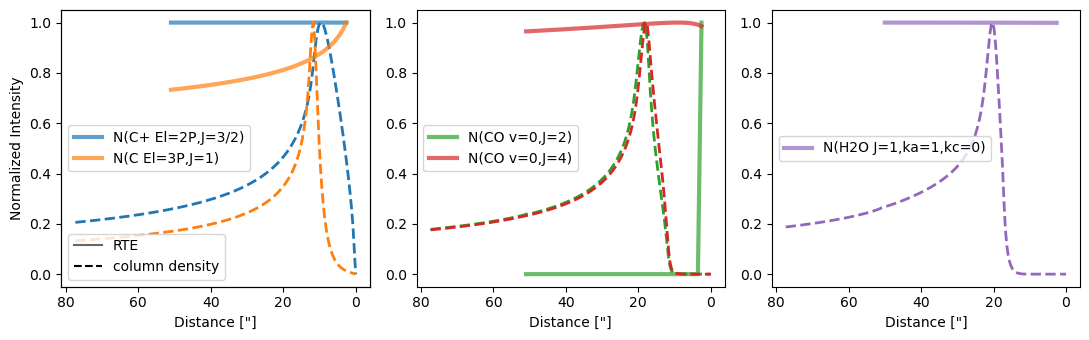

In [21]:
line_labels = ["N(C+ El=2P,J=3/2)", "N(C El=3P,J=1)", "N(CO v=0,J=2)", "N(CO v=0,J=4)", "N(H2O J=1,ka=1,kc=0)"]
line_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
linenames = ["n(C+ El=2P,J=3/2)", "n(C El=3P,J=1)", "n(CO v=0,J=2)", "n(CO v=0,J=4)", "n(H2O J=1,ka=1,kc=0)"]

Rcloud_pc = 5*u.pc
Rcloud_cm = (Rcloud_pc.to(u.cm)).value
dmax = models["thick_p5e6_h2_surfb"][qtydict["Distance"]][-1]
barr_cm = np.linspace(0.999*Rcloud_cm, Rcloud_cm - dmax, 50)
darr_arcsec = dist_2_arcsec((Rcloud_cm - barr_cm)*u.cm).value

barr_pc = np.linspace(4.85, 5, 200)*u.pc
colden_xarr_arcsec = dist_2_arcsec((Rcloud_pc - barr_pc)).value

fig_rte, axs_rte = plt.subplots(1, 3, figsize=(11, 3.5))
ax1_twin = axs_rte[0].twinx()
ax1_twin.set_yticks([])

ax1_twin.plot(np.nan, np.nan, "k-", alpha=0.6, label="RTE")
ax1_twin.plot(np.nan, np.nan, "k--", label="column density")
# ax1_twin.plot(np.nan, np.nan, "k-.", label="convolved")

for iline, (line, sline) in enumerate([(Icp, tcp), (Ic, tc), (I12co_2_1, t12co_2_1), (I12co_4_3, t12co_4_3), (Ih2o, th2o)]):
    intensity = np.array([line[i][0][-1] for i in range(len(line))])
    intensity = intensity/intensity.max()
    if iline < 2:
        axs_rte[0].plot(darr_arcsec, intensity, c=line_colors[iline], lw=3, alpha=0.7, label=line_labels[iline])
        axs_rte[0].plot(colden_xarr_arcsec, column_densities[iline]/column_densities[iline].max(), "--", lw=2, c=line_colors[iline])
    elif iline < 4:
        axs_rte[1].plot(darr_arcsec, intensity, c=line_colors[iline], lw=3, alpha=0.7, label=line_labels[iline])
        axs_rte[1].plot(colden_xarr_arcsec, column_densities[iline]/column_densities[iline].max(), "--", lw=2, c=line_colors[iline])
    else:
        axs_rte[2].plot(darr_arcsec[:-1], intensity, c=line_colors[iline], lw=3, alpha=0.7, label=line_labels[iline])
        axs_rte[2].plot(colden_xarr_arcsec, column_densities[iline]/column_densities[iline].max(), "--", lw=2, c=line_colors[iline])

for ax in axs_rte:
    ax.legend(loc="center left")
    ax.set_xlabel(f'Distance ["]')
    # ax.set_xlim([-2, 80])
    ax.invert_xaxis()
ax1_twin.legend(loc="lower left")
axs_rte[0].set_ylabel("Normalized Intensity")
fig_rte.tight_layout()
# fig_rte.savefig(figure_path+"rte_comparison.pdf", bbox_inches="tight", pad_inches=0)

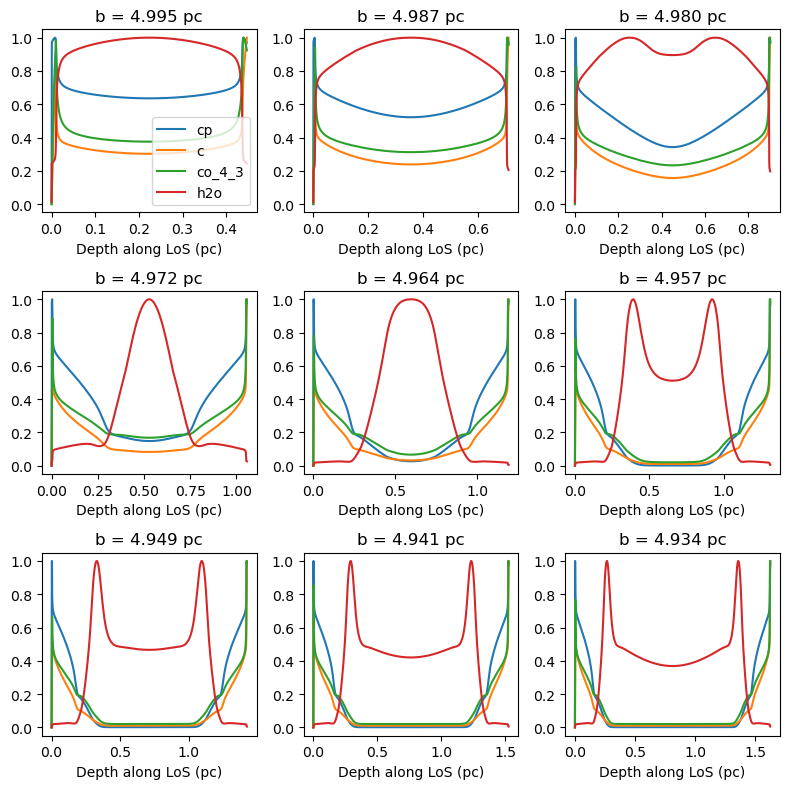

In [22]:
fig_rt, axs_rt = plt.subplots(3, 3, figsize=(8, 8))

for iax, i in enumerate(range(0, len(Icp), 4)[:9]):    
    axs_rt[iax//3, iax%3].plot(tcp[i]*u.cm.to(u.pc), Icp[i].T/Icp[i].max(), label="cp")    
    axs_rt[iax//3, iax%3].plot(tc[i]*u.cm.to(u.pc), Ic[i].T/Ic[i].max(), label="c")    
    axs_rt[iax//3, iax%3].plot(t12co_4_3[i]*u.cm.to(u.pc), I12co_4_3[i].T/I12co_4_3[i].max(), label="co_4_3")    
    # axs_rt[iax//3, iax%3].plot(t12co_2_1[i]*u.cm.to(u.pc), I12co_2_1[i].T/I12co_2_1[i].max(), label="co_2_1")    
    axs_rt[iax//3, iax%3].plot(th2o[i]*u.cm.to(u.pc), Ih2o[i].T/Ih2o[i].max(), label="h2o")    
    axs_rt[iax//3, iax%3].set_xlabel("Depth along LoS (pc)")
    axs_rt[iax//3, iax%3].set_title(f"b = {bcp[i]*u.cm.to(u.pc):.3f} pc")

axs_rt[0, 0].legend()

fig_rt.tight_layout()

#### step 3: solve the radiative transfer equation with line profile

In [26]:
def lineprofile(nu, nu0, T, amu, vturb=2*u.km/u.s):
    sigma = doppler_sigma(T, amu, nu0, vturb)
    return np.exp(-(nu - nu0)**2/2/sigma**2)/sigma/np.sqrt(2*np.pi)

def doppler_sigma(T, amu, nu0, vturb=2*u.km/u.s):
    dnuD = nu0*np.sqrt(2*const.k_B*T/amu/const.u + vturb**2)/const.c
    return dnuD/np.sqrt(2)   